In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from mobius import VirtualTarget, ForceField

In [175]:
def plot_logbook(logbook, minimum_score):
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    size_avgs = logbook.select("avg")

    fig, ax1 = plt.subplots(figsize=(15, 5))
    line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    
    line3 = ax1.plot(np.linspace(0, np.max(gen), np.max(gen)), [minimum_score] * np.max(gen), 
             '--', color='green', label='Target fitness')

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, size_avgs, "r-", label="Average Fitness")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2 + line3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper right")
    
    ax1.set_ylim([0, 12])
    ax2.set_ylim([0, 20])

    plt.show()
    

def plot_distribution(logbooks, variable_name, min_score, x_labels, fig_name=None):
    i = 0
    max_gen = np.max(logbooks['gen']) + 1
    n_col = len(set(logbooks[variable_name]))
    
    fig, axarr = plt.subplots(1, n_col, figsize=(n_col*6, 12), sharey=True)

    axarr[0].set_ylabel('#Generations', fontsize=30)
    axarr[0].set_yticks(np.arange(0, max_gen + 1, 1.0))
    axarr[0].tick_params(axis='both', which='major', labelsize=20)

    for _, var_group in logbooks.groupby(variable_name):
        gens = []
        failed = 0

        for _, group in var_group.groupby('run'):
            best = group.sort_values(by=['min', 'gen']).iloc[0]
            gen = best['gen'] + 1 if best['min'] <= min_score else max_gen
            gens.append(gen)

            if gen == max_gen:
                failed += 1

        sns.set_theme(style=None)
        sns.violinplot(y=gens, cut=0, ax=axarr[i])
        sns.stripplot(y=gens, color='black', size=10, ax=axarr[i])
        axarr[i].set_ylim([-0.5, max_gen + .5])
        axarr[i].set_xlabel('%s - (F: %d)' % (x_labels[i], failed), fontsize=30)

        i += 1
    
    if fig_name is not None:
        plt.savefig(fig_name, dpi=300, bbox_inches='tight')

    plt.show()

# Increasing learning rate and parallel pool PBIL

In [162]:
class PBIL(object):
    def __init__(self, peptide_length, population_size=96, n_best=1, max_gen=20,
                 learning_rate_max=0.5, mut_prob=0.0, mut_shift=0.00, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_gen = 1
        self._max_gen = max_gen
        self._n_best = n_best
        self._learning_rate_max = learning_rate_max
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)

    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        learning_rate = self._learning_rate_max
        if self._max_gen > 0:
            learning_rate *= (self._n_gen / self._max_gen)
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                unique_amino_acids, counts = np.unique(best_peptides[:,i], return_counts=True)
                frequencies = counts / np.sum(counts)
            else:
                unique_amino_acids = [best_peptides[0][i]]
                frequencies = [1.]
            
            for unique_amino_acid, frequency in zip(unique_amino_acids, frequencies):
                j = self._AA1.index(unique_amino_acid)
                
                # Update the probability vector (exploitation)
                self._prob_vector[i, j] *= 1.0 - learning_rate
                self._prob_vector[i, j] += frequency * learning_rate

                # Mutate the probability vector (exploration)
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])
        
        self._n_gen += 1


def evaluate(individual):
    return vt.score_peptides([''.join(individual)])[0],

# Effect of the increasing learning rate

In [163]:
NLEN = 6

ff = ForceField()
vt = VirtualTarget(ff)
vt.generate_random_target_sequence(NLEN)
vt.generate_pharmacophore_from_target_sequence('AAAAAA', solvent_exposures=[0] * 6)
print(vt.target_sequence())
print(vt.score_peptides([vt.target_sequence()]))
target_sequence = vt.target_sequence()
min_score = vt.score_peptides([vt.target_sequence()])[0]

AAAAAA
[0.]


In [165]:
NGEN = 20
NIND = 96
learning_rate = 0.20

logbooks = []

for param in [0, NGEN]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i + 1, end=' ')

        #Initialize the PBIL EDA
        pbil = PBIL(peptide_length=NLEN, population_size=NIND, n_best=1, max_gen=param, 
                    learning_rate_max=learning_rate)

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("evaluate", evaluate)
        toolbox.register("generate", pbil.generate, creator.Individual)
        toolbox.register("update", pbil.update)

        # Statistics computation
        hof = tools.HallOfFame(10)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

        df = pd.DataFrame(logbook)
        df['run'] = i
        df['max_gen'] = param
        logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

0: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

20: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 



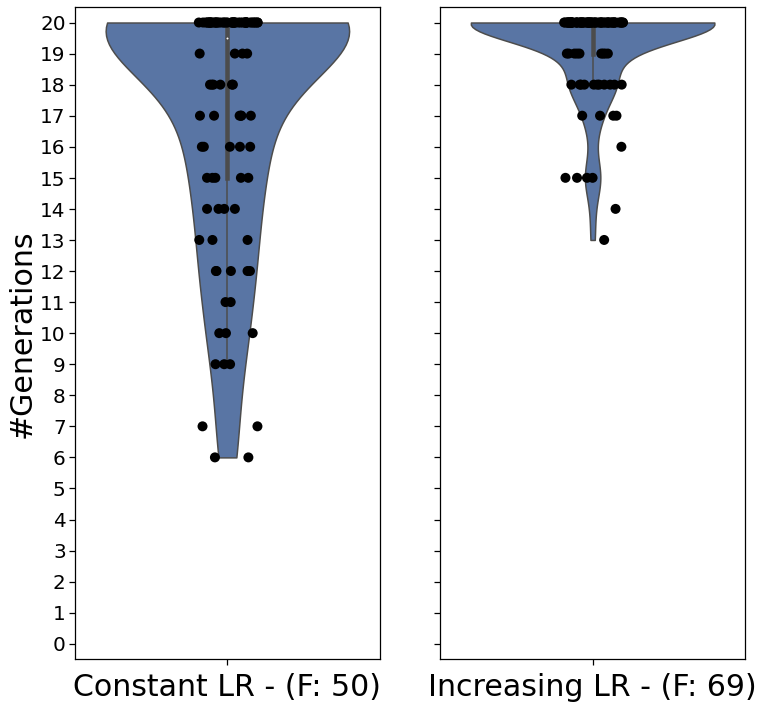

In [170]:
x_labels = ['Constant LR', 'Increasing LR']
fig_name = 'figure_peptide_AAAAAA_increasing_learning_rate_max_%.1f_ngen_%s_2.png' % (learning_rate, NGEN)
plot_distribution(logbooks, 'max_gen', min_score, x_labels, fig_name)

# Effect of the number of concurrent pools

In [173]:
NGEN = 20
NIND = 96

logbooks = []

for param in [12, 32, 48, NIND]:
    print('%s:' % param, end=' ')

    for i in range(100):
        print(i, end=' ')
        
        for j in range(0, int(96 / param)):
            #Initialize the PBIL EDA
            pbil = PBIL(peptide_length=NLEN, population_size=param, n_best=1, max_gen=0, learning_rate_max=0.5)

            creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
            creator.create("Individual", list, fitness=creator.FitnessMin)

            toolbox = base.Toolbox()
            toolbox.register("evaluate", evaluate)
            toolbox.register("generate", pbil.generate, creator.Individual)
            toolbox.register("update", pbil.update)

            # Statistics computation
            hof = tools.HallOfFame(10)
            stats = tools.Statistics(lambda ind: ind.fitness.values)
            stats.register("avg", np.mean)
            stats.register("std", np.std)
            stats.register("min", np.min)
            stats.register("max", np.max)

            pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=False, halloffame=hof)

            df = pd.DataFrame(logbook)
            df['run'] = i
            df['n_ind'] = param
            logbooks.append(df)
    
    print('\n')

logbooks = pd.concat(logbooks)

12: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

32: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

48: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

96: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

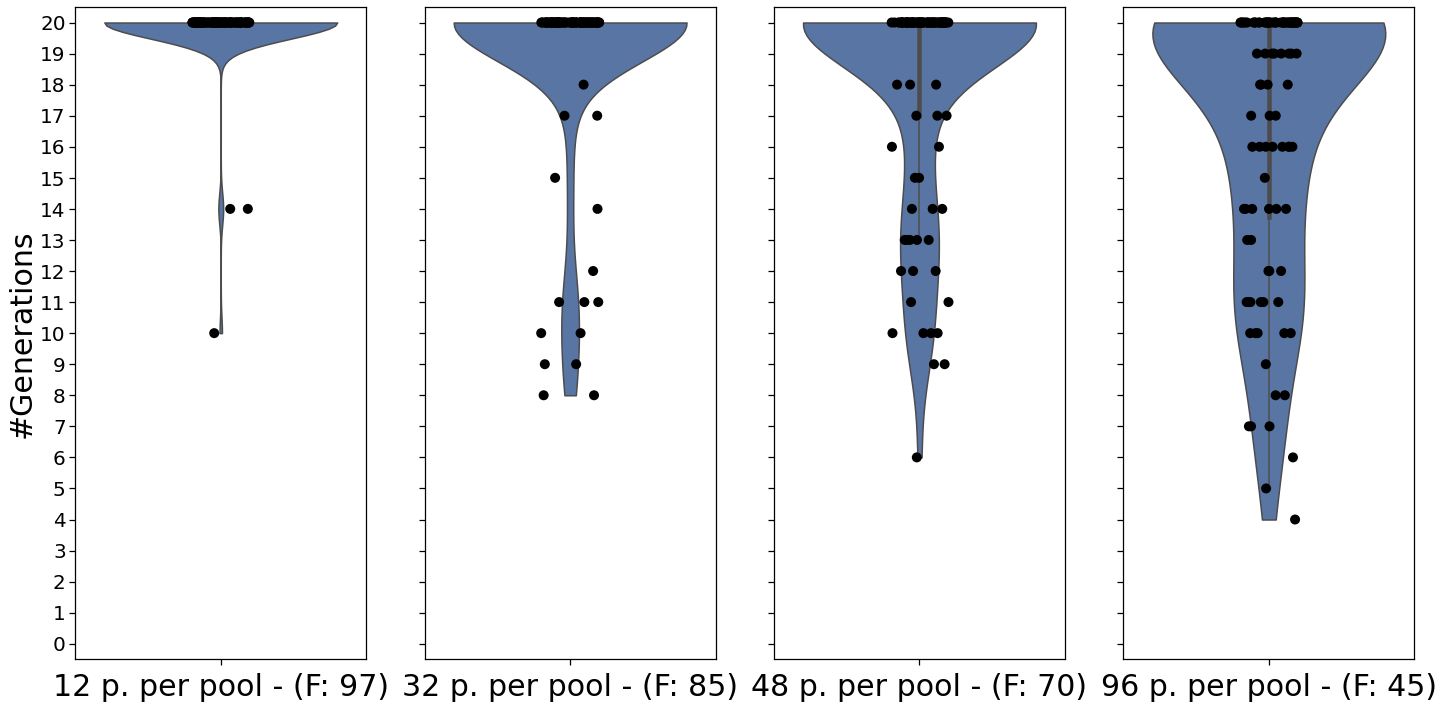

In [177]:
x_labels = ['%d p. per pool' % i for i in [12, 32, 48, NIND]]
plot_distribution(logbooks, 'n_ind', min_score, x_labels, 'figure_peptide_AAAAAA_n_ind.png')